# Explore Discharge Predictions (CamelsGB)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in config file and predictions

In [3]:
ds = xr.open_dataset(base_dir / "data/ALL_dynamic_ds.nc")
ds

<xarray.Dataset>
Dimensions:         (station_id: 671, time: 16436)
Coordinates:
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

In [4]:
run_results_dir = base_dir / "runs/cycle_bidirectional/"
run_results_dir = base_dir / "runs/runoff_cycle_lstm/"

cfg = Config(run_results_dir / "config.yml")
cfg

{'autoregressive': False,
 'batch_size': 256,
 'clip_gradient_norm': 1,
 'data_dir': PosixPath('data'),
 'device': 'cuda:0',
 'experiment_name': 'runoff_subset',
 'forecast_variables': None,
 'hidden_size': 64,
 'horizon': 0,
 'input_variables': ['temperature', 'precipitation'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'model': 'lstm',
 'n_epochs': 30,
 'num_workers': 8,
 'optimizer': 'Adam',
 'pixel_dims': ['station_id'],
 'run_dir': PosixPath('/home/tommy/spatio_temporal/runs/runoff_subset_2402_173312'),
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 356,
 'static_inputs': None,
 'target_variable': 'discharge_spec',
 'test_end_date': Timestamp('2008-12-31 00:00:00'),
 'test_start_date': Timestamp('1998-01-01 00:00:00'),
 'time_str': 'time',
 'train_end_date': Timestamp('1997-12-31 00:00:00'),
 'train_start_date': Timestamp('1988-01-01 00:00:00'),
 'validate_every_n': 1,
 'validation_end_date': Timestamp('1987-12-31 00:00:00'),
 'validation_start_date': Timestamp('1985-01-01 00:

In [6]:
import pickle 

normalizer = pickle.load((run_results_dir / "normalizer.pkl").open("rb"))

In [7]:
updated_mean = normalizer.mean_.copy()
updated_mean

<xarray.Dataset>
Dimensions:         (sample: 671)
Coordinates:
  * sample          (sample) <U13 '1001_1001' '2001_2001' ... '107001_107001'
Data variables:
    temperature     (sample) float64 7.848 7.193 6.972 ... 9.873 8.293 7.595
    precipitation   (sample) float64 2.553 3.058 3.445 ... 2.77 4.355 3.325
    discharge_spec  (sample) float64 1.446 1.908 2.271 4.121 ... 1.476 2.731 nan

# Are the train Test Periods equivalent?
- test period is wetter

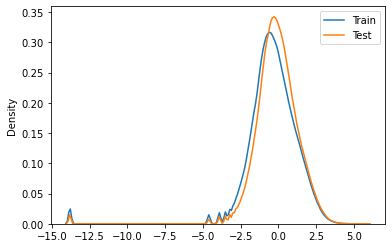

In [18]:
test = ds.sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
val = ds.sel(time=slice(cfg._cfg["validation_start_date"], cfg._cfg["validation_end_date"]))
train = ds.sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

train_log_q = np.log((train[cfg.target_variable].values.flatten() + 1e-6))
test_log_q = np.log((test[cfg.target_variable].values.flatten() + 1e-6))

sns.kdeplot(train_log_q, label="Train")
sns.kdeplot(test_log_q, label="Test")
plt.legend()

# Check loss curves

In [9]:
run_dir = Path("/Users/tommylees/github/spatio_temporal/runs/runoff_cycle_lstm")
assert run_dir.exists()
cfg.run_dir = run_dir

<AxesSubplot:>

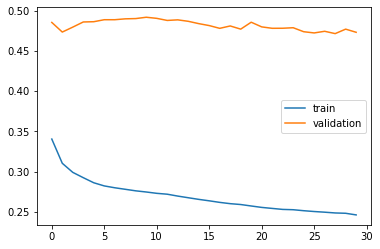

In [19]:
assert (cfg.run_dir / "losses.csv").exists(), f"{list((cfg.run_dir).iterdir())}" 

losses = pd.read_csv(cfg.run_dir / "losses.csv", index_col=0)

losses.plot()

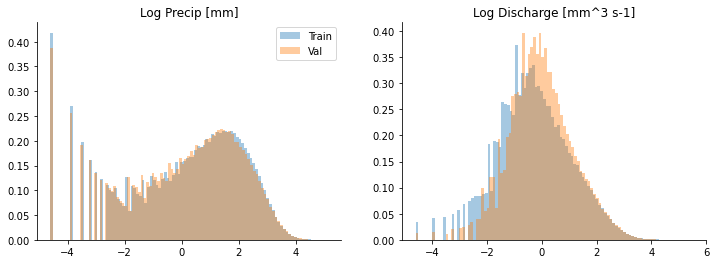

In [50]:
finite_flat = lambda arr: arr[np.isfinite(arr)]

scale = 0.5
f, axs = plt.subplots(1, 2, figsize=(12*2*scale, 8*scale))
axs[0].hist(finite_flat(np.log(train.precipitation).values), label="Train", density=True, alpha=0.4, bins=100);
axs[0].hist(finite_flat(np.log(val.precipitation).values), label="Val", density=True, alpha=0.4, bins=100);
axs[0].legend()
axs[0].set_title("Log Precip [mm]")

axs[1].hist(finite_flat(np.log(train.discharge_spec).values), label="Train", density=True, alpha=0.4, bins=100);
axs[1].hist(finite_flat(np.log(val.discharge_spec).values), label="Val", density=True, alpha=0.4, bins=100);
axs[1].set_title("Log Discharge [mm^3 s-1]")

sns.despine()

# Explore Predictions

In [11]:
xr_path = sorted(list(run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 671, time: 3662)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-22T23:59:46.966659072 ... 2008-12-...
  * pixel    (pixel) object '10002_10002' '10003_10003' ... '97002_97002'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

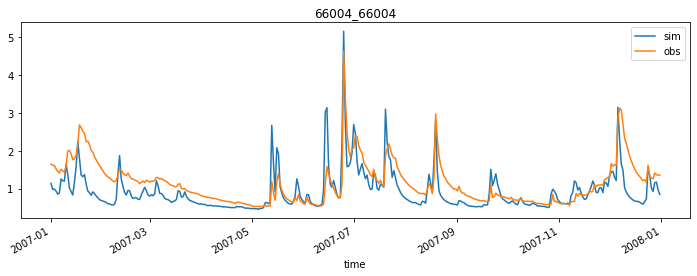

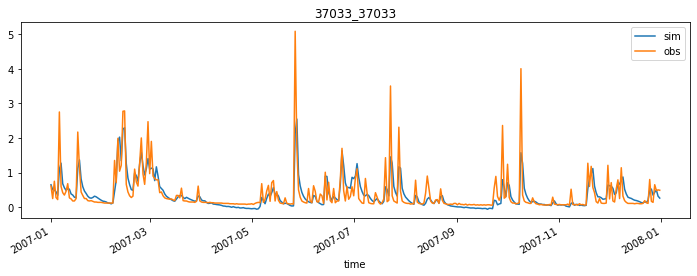

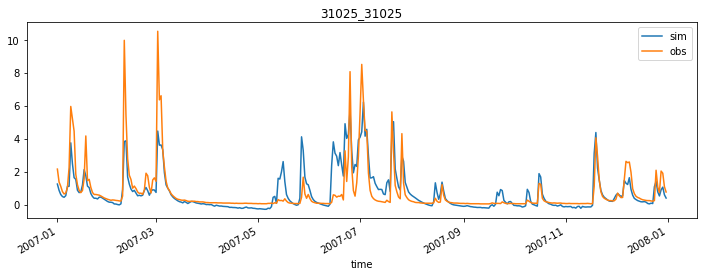

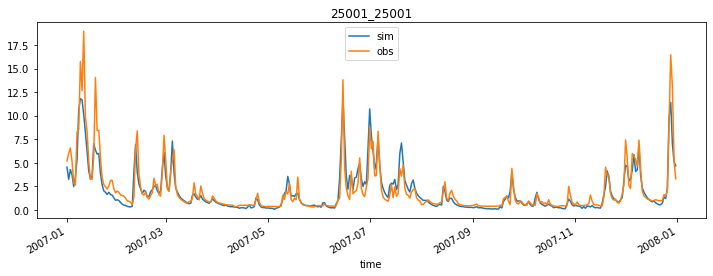

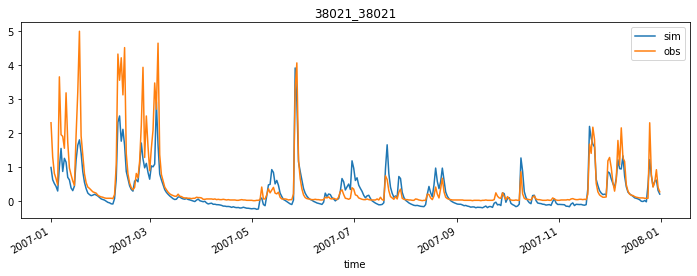

In [12]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(time="2007", pixel=pixel).to_dataframe().plot(ax=ax)
    ax.set_title(pixel)

In [13]:
preds

<xarray.Dataset>
Dimensions:  (pixel: 671, time: 3662)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-22T23:59:46.966659072 ... 2008-12-...
  * pixel    (pixel) object '10002_10002' '10003_10003' ... '97002_97002'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

# Run predictions on the training period and validation period (check overfitting)

In [14]:
trainer = Trainer(cfg, ds)
tester = Tester(cfg, ds)

/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Loading Data:   1%|          | 4/671 [00:00<00:16, 39.65it/s]

** Normalizer fit! **


Loading Data: 100%|██████████| 671/671 [00:13<00:00, 49.80it/s]


In [15]:
tester.test_dl
trainer.train_dl
trainer.valid_dl

In [16]:
if cfg.run_dir != run_dir:
    cfg.run_dir = cfg.run_dir.parent

weight_file = tester._get_weight_file(cfg, epoch=None)
epoch = int(weight_file.name.split(".")[0][-3:])

tester.model.load_state_dict(
    torch.load(weight_file, map_location=cfg.device)
)

<All keys matched successfully>

In [17]:
# make train data predictions
overfitting_tester = Tester(cfg, ds, subset="train")

Loading Data: 100%|██████████| 671/671 [00:12<00:00, 55.61it/s]


# Calculate Errors

In [ ]:
%load_ext autoreload
import sys; sys.path.append("/Users/tommylees/github/neuralhydrology")
from neuralhydrology.evaluation.metrics import calculate_all_metrics, AllNaNError

In [ ]:
all_errors = []
missing_data = []

pbar = tqdm(preds["pixel"].values, desc="Calculating Errors:")
for sid in pbar:
    pbar.set_postfix_str(sid)
    try:
        errors = calculate_all_metrics(
            sim=preds["sim"].rename({"pixel": "station_id", "time": "date"}).sel(station_id=sid),
            obs=preds["obs"].rename({"pixel": "station_id", "time": "date"}).sel(station_id=sid)
        )
        all_errors.append(pd.DataFrame({sid: errors}).T)
    except AllNaNError:
        missing_data.append(sid)
        
        
errors = pd.concat(all_errors).to_xarray().rename({"index": "pixel"})

In [ ]:
# preds.sel(pixel=missing_data)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(errors["NSE"], cumulative=True, label="NSE")
ax.axvline(errors["NSE"].mean(), color="k", ls=":", label="Mean")
ax.axvline(errors["NSE"].median(), color="k", ls="--", label="Median")
plt.legend()
sns.despine()